# <u> GUI for classification tool:
The following GUI has been developed using tkinter library of python. <br>
The tool proves an interactive platform to the user to flexibly select the training data and test it on multiple set of images. The description of GUI and its working is as follows - <br>

1.) <u>TRAINING THE MODEL</u></b>: In this section user specifies four fields -  <br>
     a) <b>Header File: </b> The path to header file.<br>
     b) <b>Image File: </b> The path to header file.<br>
     c) <b>Class Directory: </b> Path to the directory containing dataset. (NOTE: The directory should contain only the training data and no tother files.) <br>
     d) <b>Train Model(Button):</b> Trains the model to specified number of epochs and saves a copy of trained model to the working directory<br><br>
     
2.) <u>HARD CLASSIFIER</u>: There is a button which when presses classify in image, display it in the region given below the button and saves a copy of image in the working directory.<br><br>

3.) <u>SOFT CLASSIFIER</u>: In this section user specifies teo field - 
    a.) <b>Select class</b>: User specifies the class to which he wishes to classify the image. (Note: The name specified should exactly match to the class name in the directory)
    b.) <b>Threshold</b>: It is defined to eliminate the pixels that have very low confidence score.

In [1]:
# User can define the functions functions of the individual units
"""
List of possible activation functions - 
1.) tanh
2.) sigmoid
3.) relu
4.) elu
"""

# Activation function for CONV1D layer
act = 'relu'

Using TensorFlow backend.


255 uint8
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 32)             160       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 32)             8320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 16)             4112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 64)             20736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
____________________________________________________________

143/143 [==============================] - 0s 2ms/step - loss: 0.1347 - acc: 0.9441
Epoch 64/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1331 - acc: 0.9441
Epoch 65/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1313 - acc: 0.9441
Epoch 66/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1314 - acc: 0.9441
Epoch 67/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1314 - acc: 0.9441
Epoch 68/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1316 - acc: 0.9441
Epoch 69/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1311 - acc: 0.9441
Epoch 70/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1298 - acc: 0.9441
Epoch 71/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1302 - acc: 0.9441
Epoch 72/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1303 - acc: 0.9441
Epoch 73/200
143/143 [=====================

Epoch 145/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1251 - acc: 0.9441
Epoch 146/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1243 - acc: 0.9441
Epoch 147/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1244 - acc: 0.9441
Epoch 148/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1245 - acc: 0.9441
Epoch 149/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1251 - acc: 0.9441
Epoch 150/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1248 - acc: 0.9441
Epoch 151/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1237 - acc: 0.9441
Epoch 152/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1267 - acc: 0.9441
Epoch 153/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1255 - acc: 0.9441
Epoch 154/200
143/143 [==============================] - 0s 2ms/step - loss: 0.1240 - acc: 0.9441
Epoch 155/200
143/14

<IPython.core.display.Javascript object>


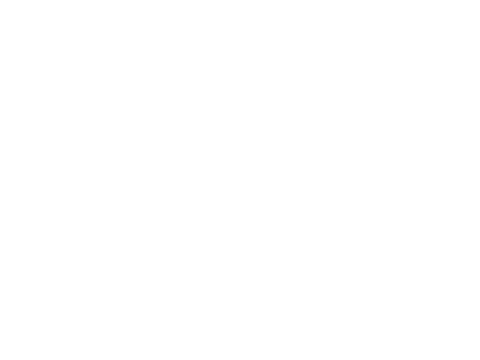

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import pickle
import matplotlib.pyplot as plt
from osgeo import gdal
from keras.layers import Dense, Conv1D, Input, MaxPooling1D, Flatten, Dropout, LSTM
from keras import Sequential
from keras.utils import np_utils
from PIL import Image
from keras.models import load_model
import array
import sys
import os
%matplotlib notebook
from utils import hdr_read, ReadBilFile, thresholding, linear_stretch, display_save_image, extract_membership
seed = 7
np.random.seed(seed)


# Function for training and saving the model
# --------------------------------------------------------->>
def training_model():
    
    header_name = entry2.get()
    file_name = entry3.get()
    directory = entry4.get()
    epoch = entry5.get()
    
    epoch = int(epoch)
    
    directory = directory.replace(os.sep, '/')
    directory = directory + '/'
    
    header_name = header_name.replace(os.sep, '/')

    file_name = file_name.replace(os.sep, '/')
    
    
    row, col, bands, datatype = hdr_read(header_name)
    x_test = ReadBilFile(file_name, bands, row*col)
    x_test = x_test.reshape(row*col, bands, 1)
    x_test = x_test / 2**8-1


    y_test = np.zeros([row*col], dtype=np.uint8)   #Each pixel will belong to one class, so total no. of outputs=rows*columns


    items = os.listdir(directory)
    path = items
    c_c = len(path)
    c_l = {items[i] : i for i in range(0, len(items))}

    values = []
    clicks={}

    for address in path:          # function to know the total number of clicks of each class
        with open(directory+address, "rb") as f:
            k = len(f.read())
            clicks[address] = (k // 2 // bands) if (k // 2 // bands) < 400 else (k // 2 // bands) // 4


    for address in path:          # function (VALUES) returns the value of all the pixels (len(values) = total_clicks * 4)
        with open(directory+address, "rb") as f:
            b = array.array("H")
            b.fromfile(f, clicks[address]*bands)
            if sys.byteorder == "little":
                b.byteswap()
            for v in b:
                values.append(v)


    # Creation of training set
    ll = (len(values))       # = total_clicks * 4
    rex = ll // bands        # = total clicks


    # Features
    f_in = np.zeros([ll], dtype=np.uint8)
    x = 0
    for i in range(ll):
        f_in[x] = values[i]
        x += 1

    x_train = f_in.reshape(rex, bands)
    x_train = x_train / 2**8-1                         # Normalising dataset to facilitate fast training

    # Labels
    y_train = np.zeros([rex], dtype=np.uint8)
    mark = 0                              # Creating label file (Mark does bifurcation of each class)
    for add in path:                      #  outer loop iterates over each class
        for i in range(clicks[add]):      # Inner loop assigns 1, 2, 3 based on c_1 dictionary to each pixel location
            y_train[mark+i] = c_l[add]
        mark = mark + clicks[add]


    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    n_classes = c_c
    y_test_new = np.zeros([row * col, c_c], dtype=np.uint8)


    X = x_train.reshape(x_train.shape[0], bands, 1)


    # MODEL

    model = Sequential()

    model.add(Conv1D(32, 4, activation=act, padding='same', input_shape=(4, 1)))
    model.add(LSTM(32, return_sequences=True))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(16, 8, activation=act, padding='same'))
    model.add(LSTM(64, return_sequences=True))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(16, 8, activation=act, padding='same'))
    model.add(LSTM(128))
    model.add(Dense(n_classes, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    model.fit(X, y_train, batch_size=10, epochs=epoch)


    # Save the trained model.
    model.save("model_saved.h5")
    print("Saved model to disk")
    
    #model = load_model('model_saved.h5')
    # summarize model.
    #model.summary()

# --------------------------------------------------------->>





# Function for Hard Classification
# --------------------------------------------------------->>
def hard_classify():
    model = load_model('model_saved.h5')
    
    root = tk.Toplevel()

    header_name = entry2.get()
    file_name = entry3.get()
    
    header_name = header_name.replace(os.sep, '/')

    file_name = file_name.replace(os.sep, '/')
    
    
    row, col, bands, datatype = hdr_read(header_name)
    x_test = ReadBilFile(file_name, bands, row*col)
    x_test = x_test.reshape(row*col, bands, 1)
    x_test = x_test / 2**8-1

    y_test_new = model.predict(x_test, batch_size=50)
    y_test1 = np.argmax(y_test_new, axis=1)

    display_save_image(y_test1, row, col, 'hard_classified')

    canvas_hard = tk.Canvas(frame2, bg="black", height=250, width=300)
    canvas_hard.place(relx = 0.01, rely = 0.35, relwidth = 0.98, relheight = 0.64)

    # Escape / raw string literal
    one = tk.PhotoImage(file='hard_classified.png')
    root.one = one  # to prevent the image garbage collected.
    canvas_hard.create_image((0,0), image=one, anchor='nw')
# --------------------------------------------------------->>
    

    
    
    
# Function for Soft Classification
#----------------------------------------------------------->>
def soft_classify():
    model = load_model('model_saved.h5')


    header_name = entry2.get()
    file_name = entry3.get()
    directory = entry4.get()
    category = entry9.get()
    threshold = float(entry10.get())
    
    directory = directory.replace(os.sep, '/')
    directory = directory + '/'
    
    header_name = header_name.replace(os.sep, '/')

    file_name = file_name.replace(os.sep, '/')
    
    

    row, col, bands, datatype = hdr_read(header_name)
    x_test = ReadBilFile(file_name, bands, row*col)
    x_test = x_test.reshape(row*col, bands, 1)
    x_test = x_test / 2**8-1


    y_test_new = model.predict(x_test, batch_size=50)
    items = os.listdir(directory)
    path = items
    c_c = len(path)
    c_l = {items[i] : i for i in range(0, len(items))}
    arg = c_l[category]
    print(arg)

    y1 = extract_membership(y_test_new, arg)
    y1_th = thresholding(y1, threshold)
    y1_std = linear_stretch(y1_th)

    strg = category
    name = 'soft'+ strg

    display_save_image(y1_std, row, col, name)

    canvas_soft = tk.Canvas(frame3, bg="black", height=250, width=300)
    canvas_soft.place(relx = 0.01, rely = 0.35, relwidth = 0.98, relheight = 0.64)

    # Escape / raw string literal
    one = tk.PhotoImage(file=name+'.png')
    root.one = one  # to prevent the image garbage collected.
    canvas_soft.create_image((0,0), image=one, anchor='nw') 
#----------------------------------------------------------->>





import tkinter as tk
from tkinter import font

HEIGHT = 700
WIDTH = 650

root = tk.Tk()

root.title('Classifier Tool (Hybrid CNN-RNN Model)')

canvas = tk.Canvas(root, height = HEIGHT, width = WIDTH, bg='black')
canvas.pack()


frame1 = tk.Frame(root, bg = '#39383A', bd = 10)
frame1.place(relx = 0.01, rely = 0.01, relwidth = 0.98, relheight = 0.4)

name = tk.Label(frame1, text = "- developed by Anumit Garg", font=("Arial", 8), bg="#39383A", fg="white" )
name.place(relx = 0.75, rely = 0.95, relwidth = 0.3, relheight = 0.1)


label1 = tk.Label(frame1, text = "TRAINING THE MODEL", font=("Times", 17), bg="#39383A", fg="white" )
label1.place(relx = 0.3, rely = 0, relwidth = 0.4, relheight = 0.1)
f = font.Font(label1, label1.cget("font"))
f.configure(underline=True)
label1.configure(font=f)



label2 = tk.Label(frame1, text = "HEADER FILE", font=("Times", 12), bg="#39383A", fg="white")
label2.place(relx = 0.01, rely = 0.2, relwidth = 0.3, relheight = 0.07)

entry2 = tk.Entry(frame1, font= 40)
entry2.place(relx = 0.33, rely = 0.2, relwidth = 0.56, relheight = 0.07)




label3 = tk.Label(frame1, text = "IMAGE FILE", font=("Times", 12), bg="#39383A", fg="white")
label3.place(relx = 0.01, rely = 0.3, relwidth = 0.3, relheight = 0.07)

entry3 = tk.Entry(frame1, font= 40)
entry3.place(relx = 0.33, rely = 0.3, relwidth = 0.56, relheight = 0.07)




label4 = tk.Label(frame1, text = "CLASS DIRECTORY", font=("Times", 12), bg="#39383A", fg="white")
label4.place(relx = 0.01, rely = 0.4, relwidth = 0.3, relheight = 0.07)

entry4 = tk.Entry(frame1, font= 40)
entry4.place(relx = 0.33, rely = 0.4, relwidth = 0.56, relheight = 0.07)



label5 = tk.Label(frame1, text = "EPOCHS", font=("Times", 12), bg="#39383A", fg="white")
label5.place(relx = 0.01, rely = 0.5, relwidth = 0.3, relheight = 0.07)

entry5 = tk.Entry(frame1, font= 40)
entry5.place(relx = 0.33, rely = 0.5, relwidth = 0.56, relheight = 0.07)




button5 = tk.Button(frame1, text = "TRAIN MODEL", font=("Times", 15), bg="#6D54EC", fg="black" , command = training_model)
button5.place(relx = 0.3, rely = 0.65, relwidth = 0.4, relheight = 0.3)






# Hard Classifier

frame2 = tk.Frame(root, bg = '#39383A', bd = 10)
frame2.place(relx = 0.01, rely = 0.42, relwidth = 0.48, relheight = 0.57)

label6 = tk.Label(frame2, text = "HARD CLASSIFIER", font=("Times", 12), bg="#39383A", fg="white")
label6.place(relx = 0.2, rely = 0, relwidth = 0.6, relheight = 0.07)

fh = font.Font(label6, label6.cget("font"))
fh.configure(underline=True)
label6.configure(font=fh)

desc = tk.Label(frame2, text = "Hard Classification:\n A pixel can belong only to one category.", font=("Times", 12), bg="#39383A", fg="white")
desc.place(relx = 0.01, rely = 0.1, relwidth = 0.98, relheight = 0.14) 

button6 = tk.Button(frame2, text = "CLASSIFY", font = 40, bg="#6D54EC", fg="black", command = hard_classify)
button6.place(relx = 0.3, rely = 0.26, relwidth = 0.4, relheight = 0.07)

canvas_hard = tk.Canvas(frame2, bg="black", height=250, width=300)
canvas_hard.place(relx = 0.01, rely = 0.35, relwidth = 0.98, relheight = 0.64)






# Soft Classifier

frame3 = tk.Frame(root, bg = '#39383A', bd = 10)
frame3.place(relx = 0.51, rely = 0.42, relwidth = 0.48, relheight = 0.57)

label6 = tk.Label(frame3, text = "SOFT CLASSIFIER", font=("Times", 12), bg="#39383A", fg="white")
label6.place(relx = 0.2, rely = 0, relwidth = 0.6, relheight = 0.07)

fs = font.Font(label6, label6.cget("font"))
fs.configure(underline=True)
label6.configure(font=fs)

label7 = tk.Label(frame3, text = "Select Class", font=("Times", 12), bg="#39383A", fg="white")
label7.place(relx = 0.01, rely = 0.1, relwidth = 0.3, relheight = 0.06)

entry9 = tk.Entry(frame3, font= 40)
entry9.place(relx = 0.33, rely = 0.1, relwidth = 0.56, relheight = 0.06)


label10 = tk.Label(frame3, text = "Threshold", font=("Times", 12), bg="#39383A", fg="white")
label10.place(relx = 0.01, rely = 0.18, relwidth = 0.3, relheight = 0.06)

entry10 = tk.Entry(frame3, font= 40)
entry10.place(relx = 0.33, rely = 0.18, relwidth = 0.56, relheight = 0.06)


button7 = tk.Button(frame3, text = "CLASSIFY", font = 40, bg="#6D54EC", fg="black", command = soft_classify)
button7.place(relx = 0.3, rely = 0.26, relwidth = 0.4, relheight = 0.07)


canvas_soft = tk.Canvas(frame3, bg="black", height=250, width=300)
canvas_soft.place(relx = 0.01, rely = 0.35, relwidth = 0.98, relheight = 0.64)




#root.after(2000, lambda: root.destroy())


root.mainloop()